In [6]:
ls ..

Dockerfile  Makefile   artifacts/  changelog.md  poetry.lock     src/
LICENSE     README.md  bin/        notebooks/    pyproject.toml


In [7]:
import dotenv
import os
import logging
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load env variables from .env
dotenv.load_dotenv()

True

In [8]:
VICTIMIZATION_DATASET_URL = (
    "https://data.ojp.usdoj.gov/resource/gcuy-rt5g.json?$limit=100000"
)

In [9]:
class DataLoader:
    """Class to load NCVS data from."""

    @staticmethod
    def load_data() -> pd.DataFrame:
        """Load raw NCVS data using their API endpoint.

        Returns:
            pd.DataFrame: raw NCVS dataset
        """

        try:
            data_json = requests.get(VICTIMIZATION_DATASET_URL).json()
        except Exception as e:
            logging.error(
                {"message": "Could not load victimization data.", "detail": str(e)}
            )
        df = pd.DataFrame(data_json)
        return df

In [10]:
# Load NCVS 
df = DataLoader.load_data()
df.head()

,idper,yearq,year,ager,sex,hispanic,race,race_ethnicity,hincome1,hincome2,...,weapcat,injury,serious,treatment,offenderage,offendersex,offtracenew,wgtviccy,series,newwgt
0,210176836193319999999923301,2004.1,2004,2,2,2,2,2,1,-1,...,0,0,1,0,3,1,-1,1952.97373,1,1952.97373
1,254207015147069329204211203,2009.1,2009,1,1,2,1,1,7,-1,...,2,0,1,0,5,1,-1,5570.68773,1,5570.68773
2,210313595043196799999912102,2004.1,2004,4,1,2,1,1,5,-1,...,0,0,1,0,4,1,-1,3366.95748,1,3366.95748
3,252018211553075329282015501,2011.4,2011,3,1,1,1,6,5,-1,...,0,0,1,0,88,1,-1,6991.56061,1,6991.56061
4,210376205057919299999921201,2004.1,2004,2,1,2,1,1,6,-1,...,0,1,3,1,3,3,-1,2834.64905,1,2834.64905


In [11]:
df.columns

Index(['idper', 'yearq', 'year', 'ager', 'sex', 'hispanic', 'race',
       'race_ethnicity', 'hincome1', 'hincome2', 'marital', 'popsize',
       'region', 'msa', 'locality', 'educatn1', 'educatn2', 'veteran',
       'citizen', 'newcrime', 'newoff', 'seriousviolent', 'notify',
       'vicservices', 'locationr', 'direl', 'weapon', 'weapcat', 'injury',
       'serious', 'treatment', 'offenderage', 'offendersex', 'offtracenew',
       'wgtviccy', 'series', 'newwgt'],
      dtype='object')

## Columns Description
### Demographics
* idper (Person ID): Unique identifier. No encoded values.
* yearq (Year and Quarter): Format YYYY.Q. No encoded values.
* ager (Age): Encoded as 1-6, representing age groups like 12-17, 18-24, etc.
* sex: Encoded as 1 for Male and 2 for Female.
* hispanic (Hispanic Origin): 1 for Hispanic, 2 for Non-Hispanic, 88 for Residue.
* race: Encoded as 1-5, representing races like White, Black, American Indian, etc.
* race_ethnicity: Encoded as 1-6, combining race and Hispanic origin.
### Socioeconomic Status
* hincome1 (Annual Household Income): Encoded as 1-8, representing income ranges like <$7,500, $7,500-$14,999, etc.
* hincome2 (Imputed Income): Encoded as -1, 1-5, representing imputed income categories.
* marital (Marital Status): Encoded as 1-5, representing statuses like Never Married, Married, etc.
* educatn1 & educatn2 (Education Level): Encoded as 1-8, representing levels like No schooling, Grade school, etc.
### Geographical Information
* popsize (Population Size): Encoded as -1, 0-5, representing the size range of the place where the housing unit is located.
* region: Encoded as -1, 1-4, representing Census regions like Northeast, Midwest, etc.
* msa (Location of Residence): Encoded as 1-3, based on metropolitan statistical areas (MSAs).
* locality: Encoded as -1, 1-3, representing Urban, Suburban, Rural.
### Crime Specifics
* newcrime (Aggregate Type of Crime): Encoded as 1 for Violent Crime, 2 for Personal Theft/Larceny.
* newoff (Type of Crime): Encoded as 1-5, representing crimes like Rape/Sexual Assault, Robbery, etc.
* seriousviolent: Encoded as 1-3, representing violent crimes excluding simple assault, simple assault, and personal theft/larceny.

In [12]:
# What portion of crimes were sexual assaults / rapes?
df.newoff.value_counts() / df.shape[0]

newoff
4    0.621996
3    0.190798
2    0.105097
1    0.049791
5    0.032317
Name: count, dtype: float64

### How many crimes were of sexual nature?
Type of crime is represented by `newoff` variable, and the value of 1 indicates rape or sexual assault. This means that 4.98% of crimes were sex-related, or 3160 out of 63465 cases in the survey. Let's see what portion of those were reported.

In [13]:
sexcrimes_df = df[df.newoff == '1']
sexcrimes_df.notify.value_counts() / sexcrimes_df.shape[0]

notify
2    0.665823
1    0.320886
3    0.006962
8    0.006329
Name: count, dtype: float64

### Reporting to the police

`notify`:

       = 1 -> Yes, reported

       = 2 -> No, not reported

       = 3 -> Not known
       
       = 8 -> Residue (?)

We see only about 1/3 of the respondents reported their sexual assault to the police. However, 2/3 did not - quite a concerning number.

There could be many reasons why someone might not report a sexual assault to the police, for example:

* **Stigma and Shame**: Victims may fear societal judgment or blame.
* **Distrust of Authorities**: Concerns that the police won't take the report seriously or that the legal process will be traumatizing.
* **Fear of Retaliation**: Worry that the perpetrator or their associates may seek revenge.
* **Personal Relationships**: The perpetrator may be a family member or friend, complicating the decision to report.

Let's see if any other indicator can shade light on the difference between thos who report and those who don't.

In [14]:
sexcrimes_df = sexcrimes_df[sexcrimes_df.notify.isin(['1', '2'])]

In [15]:
reported_df = sexcrimes_df[sexcrimes_df.notify == '1']
notreported_df = sexcrimes_df[sexcrimes_df.notify == '2']

In [16]:
reported_df.sex.value_counts() / reported_df.shape[0]

sex
2    0.905325
1    0.094675
Name: count, dtype: float64

In [17]:
notreported_df.sex.value_counts() / notreported_df.shape[0]

sex
2    0.889259
1    0.110741
Name: count, dtype: float64

The share of females is very similar among thos who report and those who don't - about 90%.

<Axes: xlabel='count', ylabel='sex'>

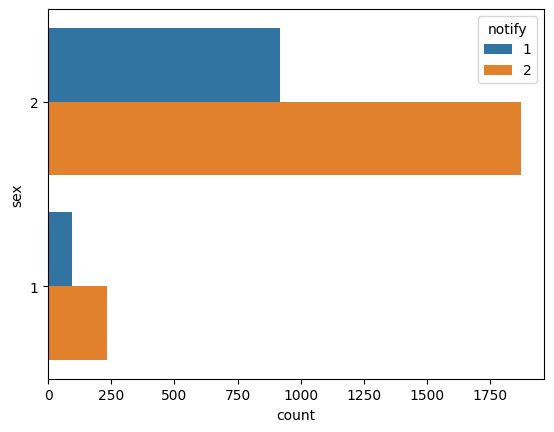

In [18]:
# Males and females have similar reporting behavior in both sets
sns.countplot(data=sexcrimes_df, y="sex", hue='notify')

<Axes: xlabel='count', ylabel='race'>

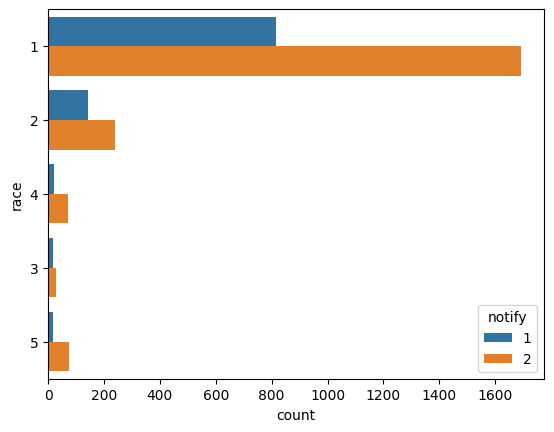

In [19]:
sns.countplot(data=sexcrimes_df, y="race", hue='notify')

In [20]:
def heatmap_notify_rate(var: str):
    source = (sexcrimes_df.groupby([var, 'notify']).notify.count() \
              / sexcrimes_df.groupby([var]).notify.count()).unstack() * 100

    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(source, annot=True, linewidths=.5, ax=ax)

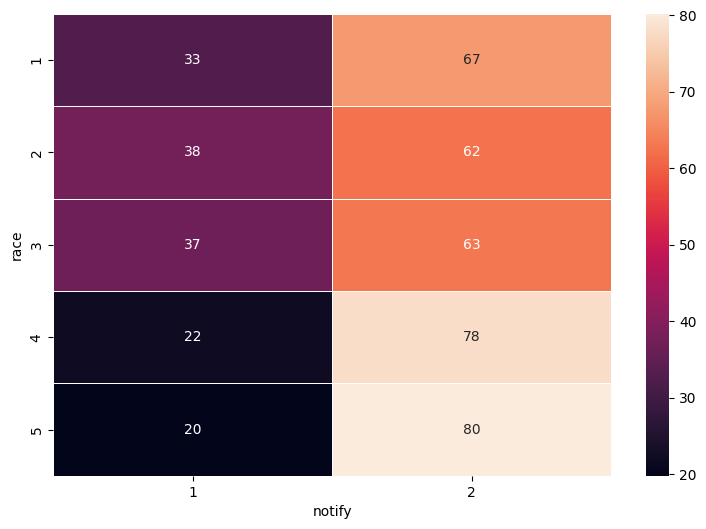

In [21]:
heatmap_notify_rate('race')

### Effect of Race of the victim on reporting
We see that black and native americans has similar reporting rate on average, with 62-63% being not reported to the police. This is followed by white american, 67% of whome did not report being a victim.
The biggest area of concern, however, seem to be **Asian Americans with 78% of sex crimes being not reported to the police**.

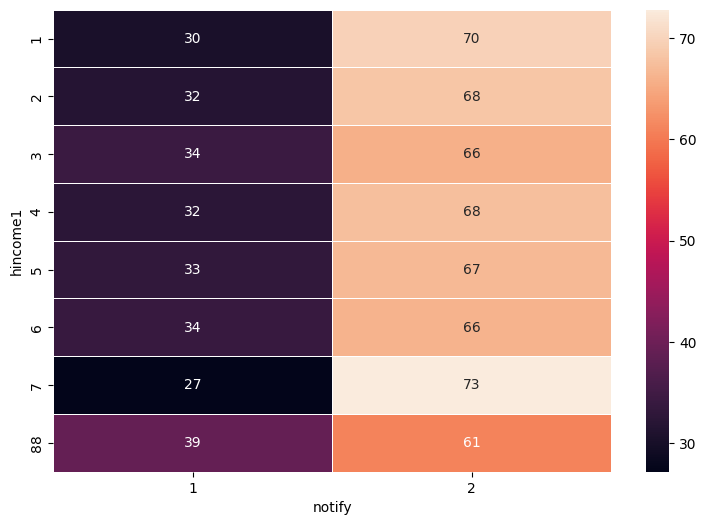

In [22]:
heatmap_notify_rate('hincome1')

Not much difference in reporting based on income

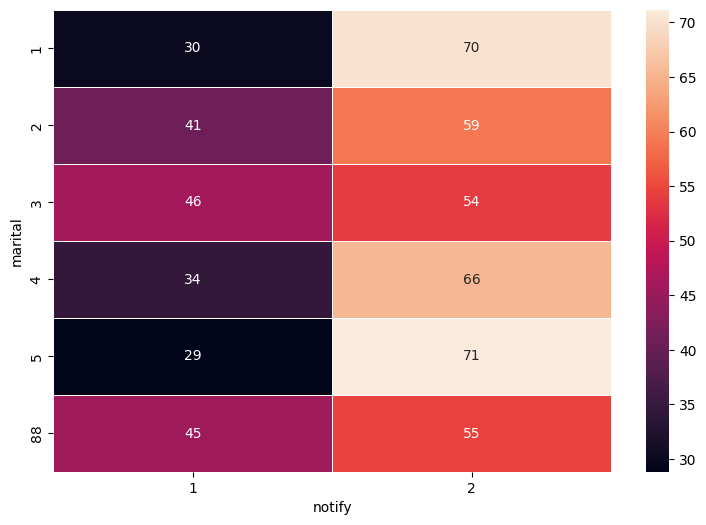

In [23]:
heatmap_notify_rate('marital')

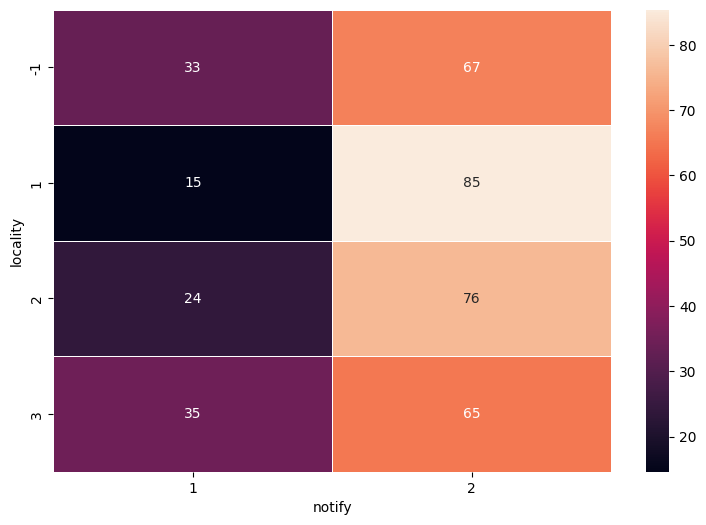

In [24]:
heatmap_notify_rate('locality')

Much lower reporting rate in urban areas.

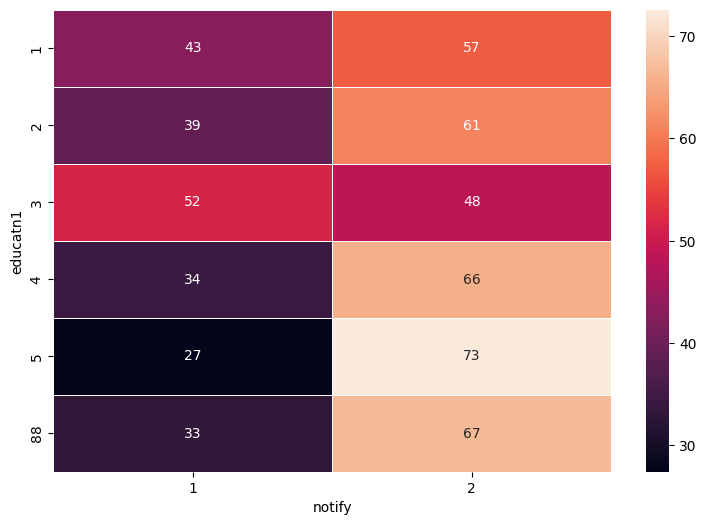

In [25]:
heatmap_notify_rate('educatn1')

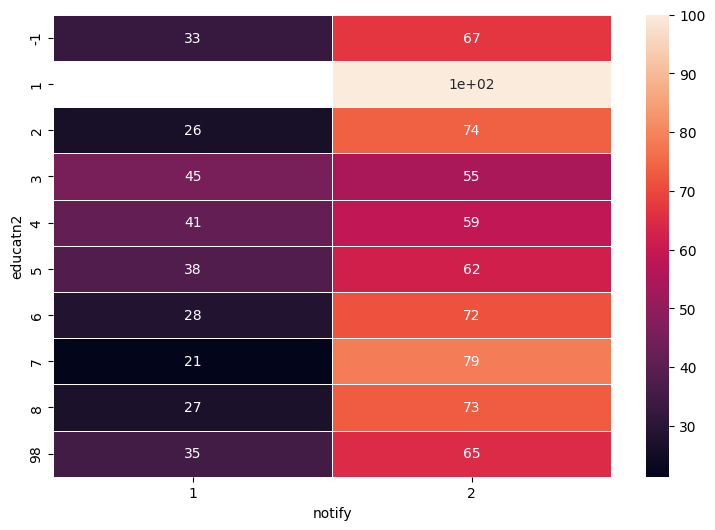

In [26]:
heatmap_notify_rate('educatn2')

Middle schooler have much higher reporting rate

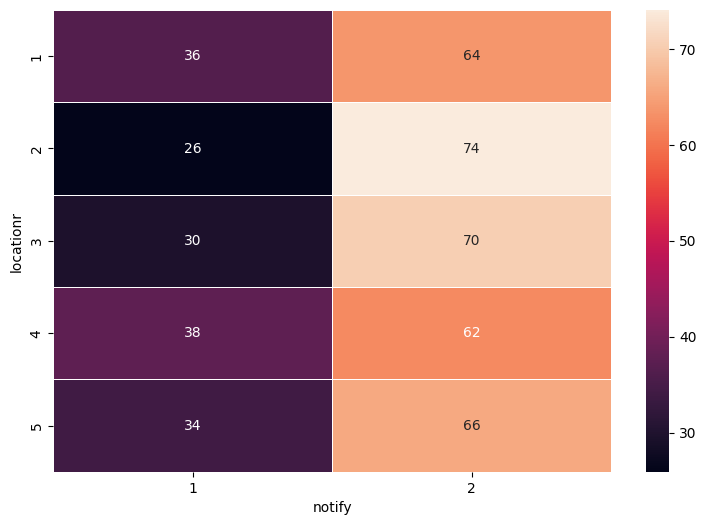

In [27]:
heatmap_notify_rate('locationr')

Crimes occuring at school have higher chance of bering reported

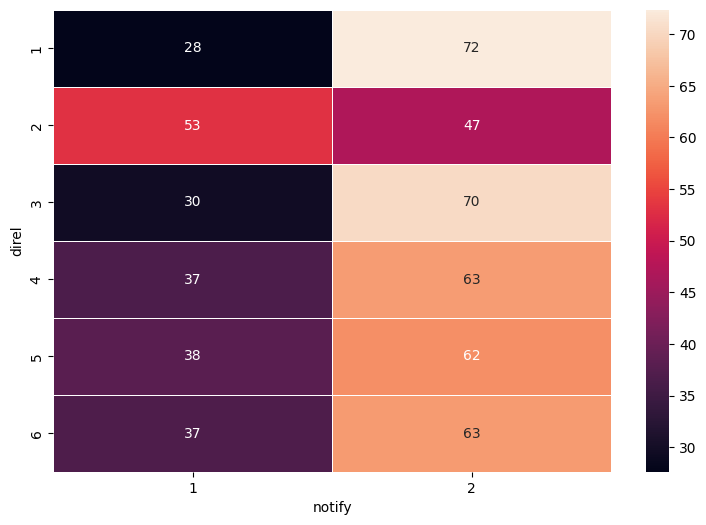

In [28]:
heatmap_notify_rate('direl')

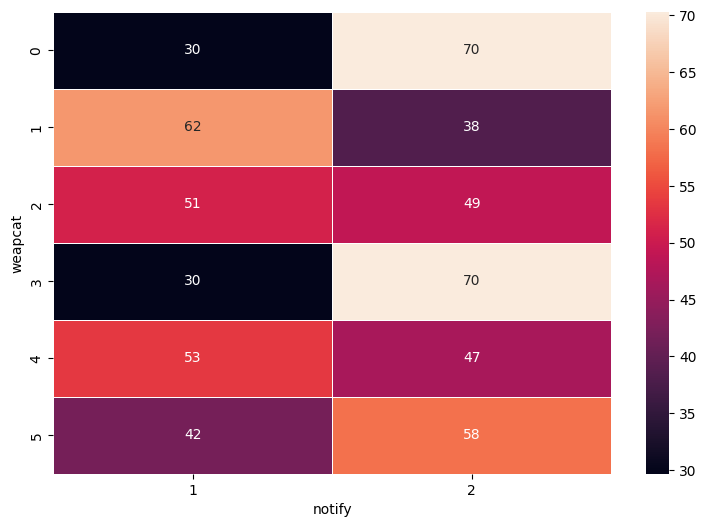

In [29]:
heatmap_notify_rate('weapcat')

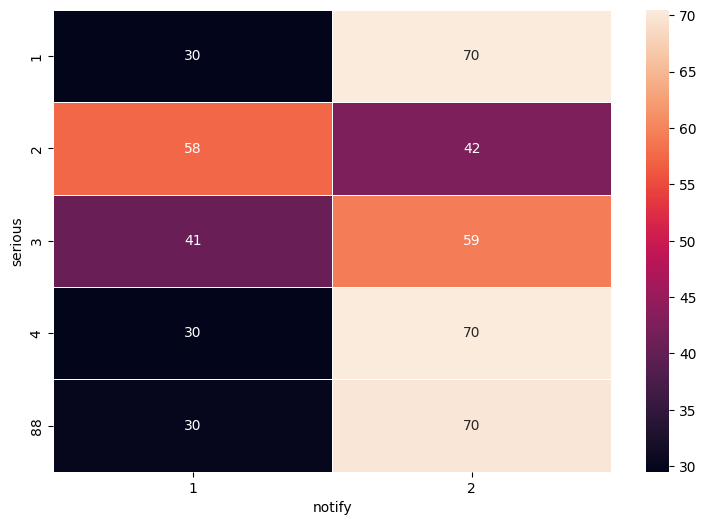

In [30]:
heatmap_notify_rate('serious')

Crime involving a weapon (especially a knife) are more likely to be reported

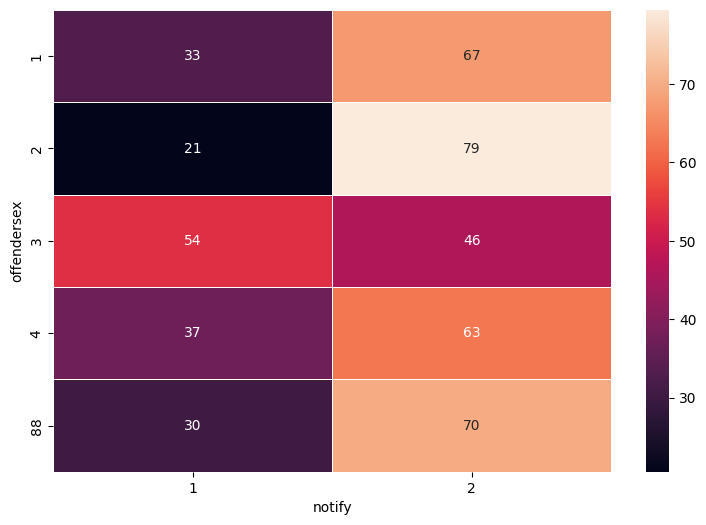

In [31]:
heatmap_notify_rate('offendersex')

Sex crimes where an offender is a female are much less likely to be reported. However, when both sexes are involved, rate of  reporting goes up to 54%

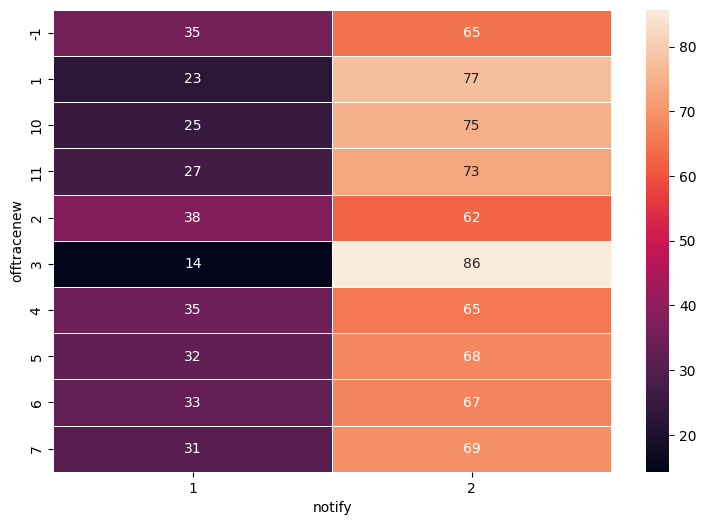

In [32]:
heatmap_notify_rate('offtracenew')

The least likley to be reported when offender is of Native American descent

## What can predict if there was a sexual assault?

In [33]:
df['rape'] = df['newoff'].apply(lambda x: 1 if x == '1' else 0)

In [34]:
df_unreported = df[df.notify == '2']

In [35]:
def heatmap_rape_rate(var: str):
    source = (df_unreported.groupby([var, 'rape']).rape.count() \
              / df_unreported.groupby([var]).rape.count()).unstack() * 100

    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(source, annot=True, linewidths=.5, ax=ax)

Let's look at all unreported crimes and go over individual factors of the case. What percentage were sexula assaults?

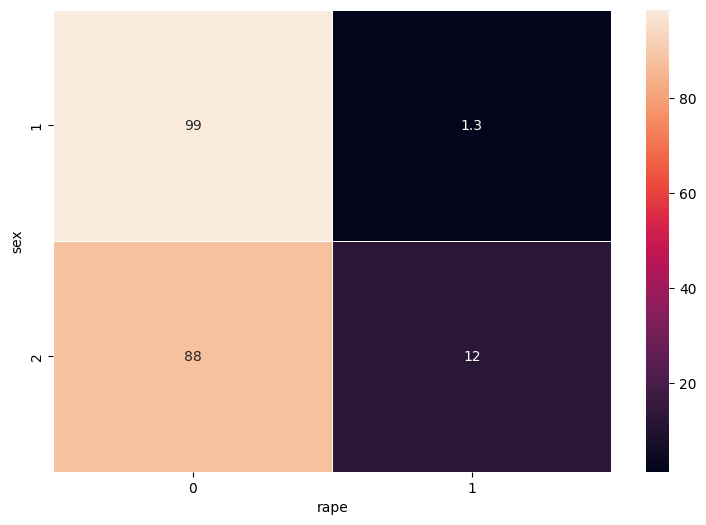

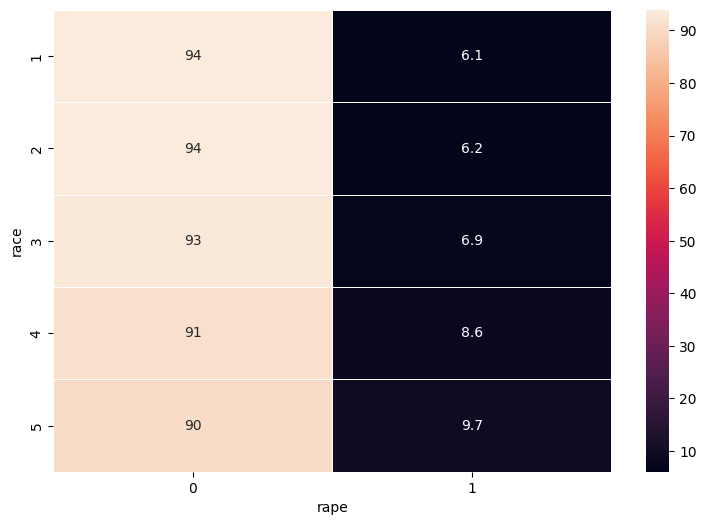

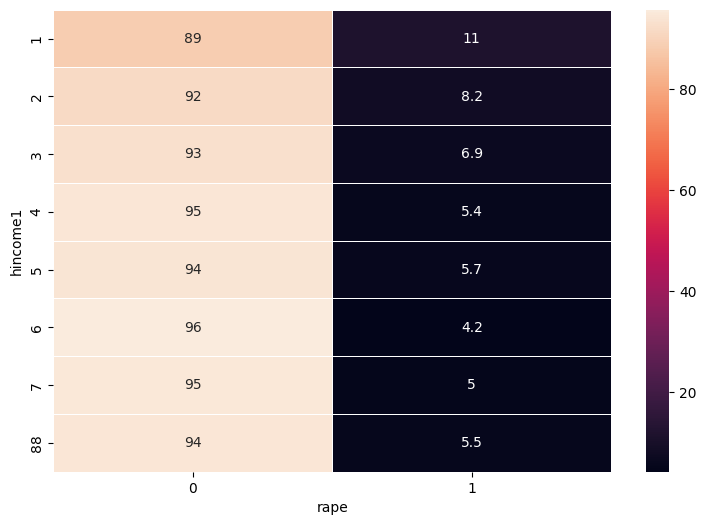

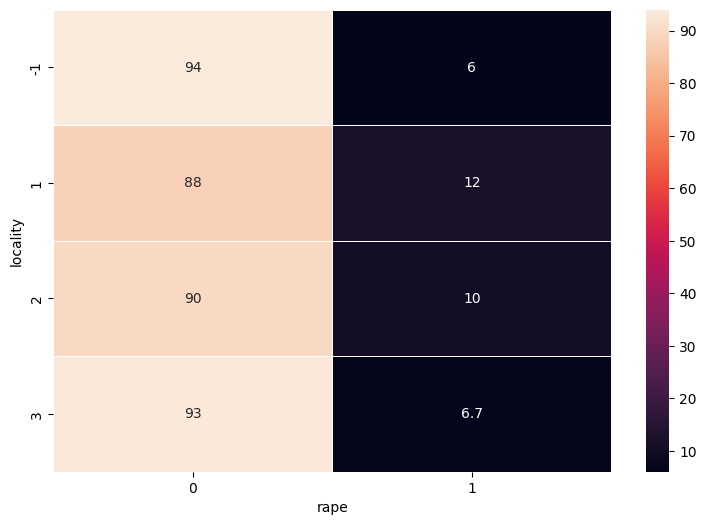

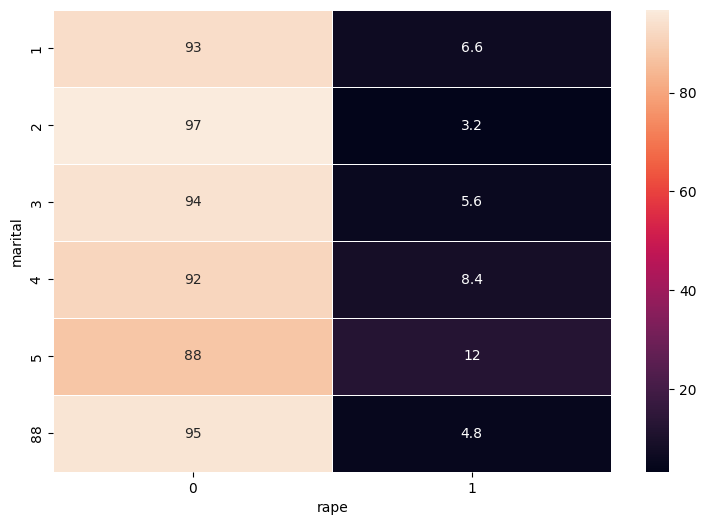

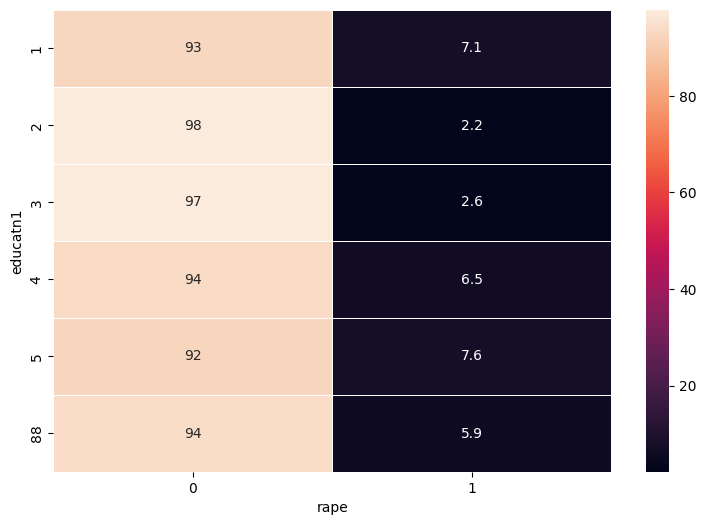

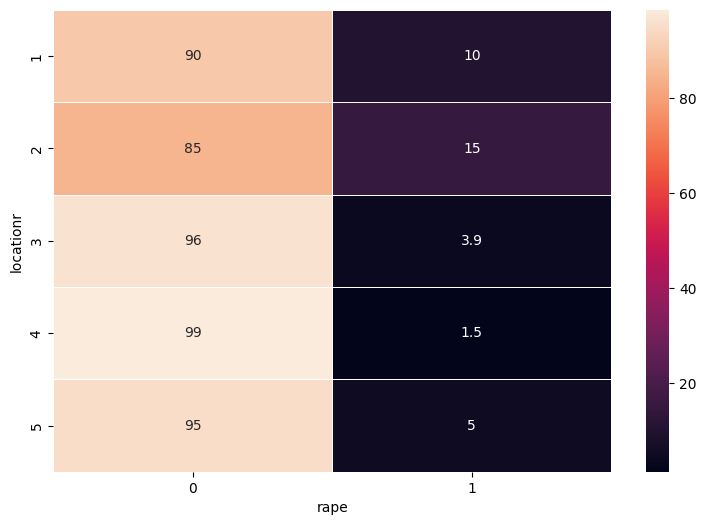

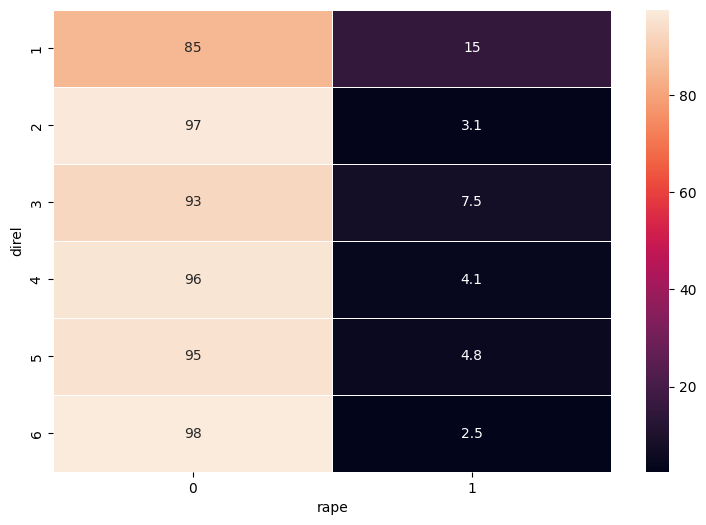

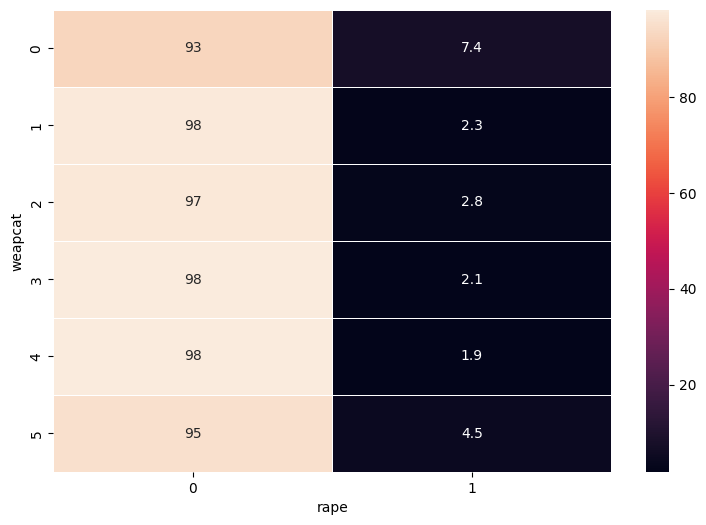

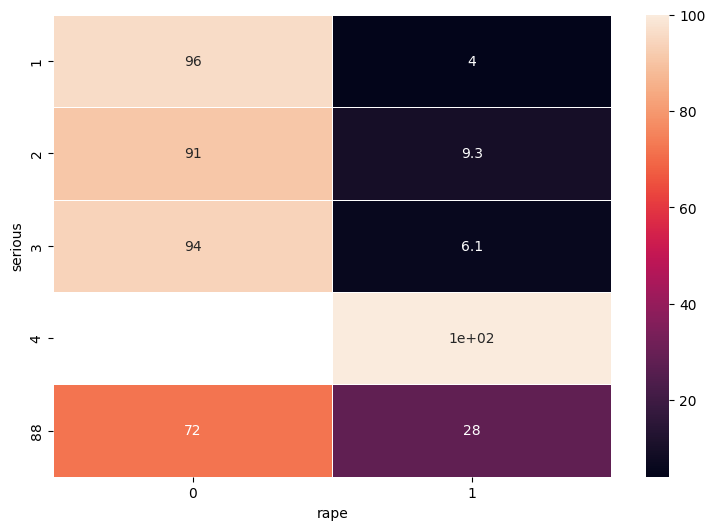

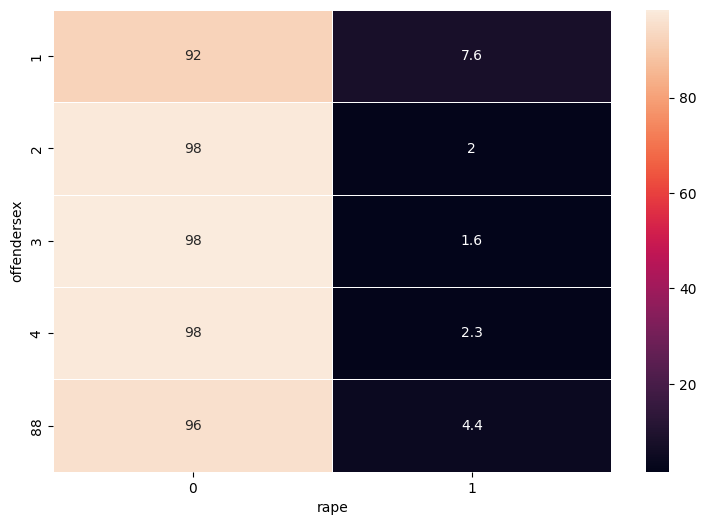

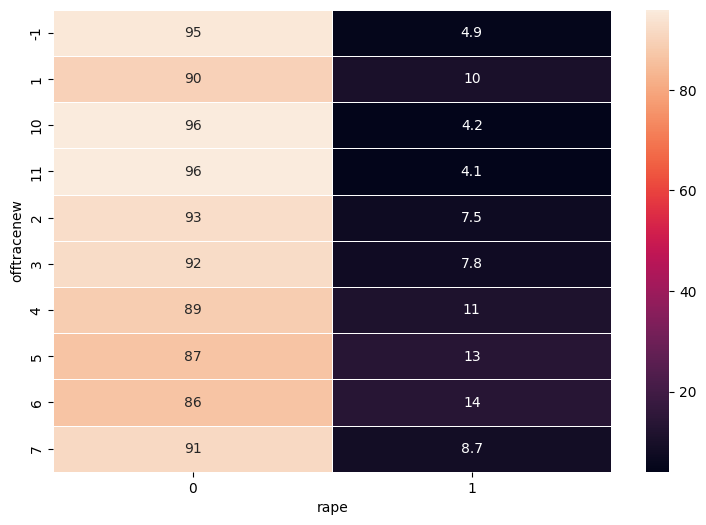

In [36]:
for var in ['sex', 'race', 'hincome1', 'locality', 'marital', 'educatn1', 'locationr',
           'direl', 'weapcat', 'serious', 'offendersex', 'offtracenew']:
    heatmap_rape_rate(var)

* Females have a much higher rate or rapes among unreported crimes: 12 % vs 1.3% for males
* The poorer person is, the more likely that rape occured
* lower rate of rapes in rural areas
* higher rate in case a separated couple
* lower rate if victim in middle or grade school

# Training

In [37]:
from data import DataLoader
df = DataLoader.create_training_dataset(serialize=False)

2023-08-26 17:55:13 logger [logger] INFO [2668] {'process': 'DataLoader.create_training_dataset', 'message': 'Started.', 'args': 'removed'} [logger.py:62]
2023-08-26 17:55:13 logger [logger] INFO [2668] {'process': 'DataLoader.load_data', 'message': 'Started.', 'args': 'removed'} [logger.py:62]
2023-08-26 17:55:18 logger [logger] INFO [2668] {'process': 'DataLoader.load_data', 'message': 'Success.', 'duration': 5.5682} [logger.py:73]
2023-08-26 17:55:18 logger [logger] INFO [2668] {'process': 'DataLoader.clean_data', 'message': 'Started.', 'args': 'removed'} [logger.py:62]
2023-08-26 17:55:19 logger [logger] INFO [2668] {'process': 'DataLoader.clean_data', 'message': 'Success.', 'duration': 1.0537} [logger.py:73]
2023-08-26 17:55:19 logger [logger] INFO [2668] {'process': 'DataLoader.create_training_dataset', 'message': 'Success.', 'duration': 6.6678} [logger.py:73]


In [38]:
from train import TrainingPipeline

In [39]:
data_train, data_val = TrainingPipeline.train_test_split(df, cutoff_year=2021)

In [75]:
data_val.is_rape.value_counts() / data_val.shape[0]

is_rape
0    0.927192
1    0.072808
Name: count, dtype: float64

In [76]:
data_train.is_rape.value_counts() / data_train.shape[0]

is_rape
0    0.950886
1    0.049114
Name: count, dtype: float64

In [51]:
pipe = TrainingPipeline(data_train)
pipe.train()

2023-08-26 17:57:03 logger [logger] INFO [2668] {'process': 'TrainingPipeline.train', 'message': 'Started.', 'args': 'removed'} [logger.py:62]
2023-08-26 17:57:03 logger [train] INFO [2668] Training model. [train.py:67]
2023-08-26 17:57:04 logger [logger] INFO [2668] {'process': 'TrainingPipeline.train', 'message': 'Success.', 'duration': 1.0415} [logger.py:73]


LGBMClassifier(max_depth=5, n_estimators=50, n_jobs=None, random_state=42)

In [52]:
pipe.evaluate(data_val)

Precision score:  0.8333333333333334
Recall score:  0.7575757575757576
F1-score score:  0.7936507936507938


In [58]:
_ = pipe.explain_model()
_.sort_values()

2023-08-26 17:58:07 logger [train] INFO [2668] {'message': 'Feature Importances', 'values': year              87
ager              42
sex               49
hispanic           1
race              13
race_ethnicity    11
hincome1          30
hincome2           4
marital           15
popsize            7
region             5
msa                4
locality           1
educatn1           7
educatn2           5
veteran            3
citizen            0
newcrime           0
seriousviolent    51
notify            19
vicservices       23
locationr         24
direl             60
weapon            47
weapcat           30
injury            40
serious           91
treatment          9
offenderage       30
offendersex       56
offtracenew       31
series             6
dtype: int32} [train.py:103]


newcrime           0
citizen            0
hispanic           1
locality           1
veteran            3
msa                4
hincome2           4
educatn2           5
region             5
series             6
educatn1           7
popsize            7
treatment          9
race_ethnicity    11
race              13
marital           15
notify            19
vicservices       23
locationr         24
weapcat           30
hincome1          30
offenderage       30
offtracenew       31
injury            40
ager              42
weapon            47
sex               49
seriousviolent    51
offendersex       56
direl             60
year              87
serious           91
dtype: int32

In [66]:
bad_features = _.sort_values().index[:13]
bad_features

Index(['newcrime', 'citizen', 'hispanic', 'locality', 'veteran', 'msa',
       'hincome2', 'educatn2', 'region', 'series', 'educatn1', 'popsize',
       'treatment'],
      dtype='object')

In [84]:
cannot_use_features = ['serious', 'notify']

In [85]:
data = df.drop([*bad_features, *cannot_use_features], axis=1)

In [86]:
data_train, data_val = TrainingPipeline.train_test_split(data, cutoff_year=2021)
data_train = data_train.drop('year', axis=1)
data_val = data_val.drop('year', axis=1)

In [87]:
pipe = TrainingPipeline(data_train)
pipe.train()

2023-08-26 18:05:54 logger [logger] INFO [2668] {'process': 'TrainingPipeline.train', 'message': 'Started.', 'args': 'removed'} [logger.py:62]
2023-08-26 18:05:54 logger [train] INFO [2668] Training model. [train.py:67]
2023-08-26 18:05:54 logger [logger] INFO [2668] {'process': 'TrainingPipeline.train', 'message': 'Success.', 'duration': 0.7442} [logger.py:73]


LGBMClassifier(max_depth=5, n_estimators=50, n_jobs=None, random_state=42)

In [88]:
pipe.evaluate(data_val)

Precision score:  0.6744186046511628
Recall score:  0.6590909090909091
F1-score score:  0.6666666666666666


In [89]:
_ = pipe.explain_model()
_.sort_values()

2023-08-26 18:05:56 logger [train] INFO [2668] {'message': 'Feature Importances', 'values': ager              77
sex               62
race              35
race_ethnicity    41
hincome1          34
marital           38
seriousviolent    51
vicservices       42
locationr         73
direl             86
weapon            42
weapcat           28
injury            49
offenderage       63
offendersex       59
offtracenew       84
dtype: int32} [train.py:103]


weapcat           28
hincome1          34
race              35
marital           38
race_ethnicity    41
vicservices       42
weapon            42
injury            49
seriousviolent    51
offendersex       59
sex               62
offenderage       63
locationr         73
ager              77
offtracenew       84
direl             86
dtype: int32

1. Relationship to the Offender

Why Important:

Intimate Partners: The likelihood of sexual assault is often higher in domestic abuse cases. The offender may use rape as another form of control or humiliation.
Acquaintances: People are more likely to let their guard down around someone they know, providing the offender an opportunity to commit sexual assault alongside another crime.

4. Age of the Offender

Why Important:

Young Offenders: Impulsivity and lack of foresight are common in younger individuals. They may commit sexual assault without premeditation when committing another crime.
Older Offenders: With age comes experience. Older offenders may have a history of crimes that include sexual assault, making it a calculated part of their criminal activity.

7. Race of the Offender
   
Why Important:
Systemic Bias: If a particular racial group is disproportionately represented in these crimes, it could point to systemic issues like racial profiling or economic disadvantage.
Cultural Factors: Some communities may have cultural norms that make sexual assault more prevalent, although this is a sensitive and complex issue to analyze.

9. Location of the Crime
    
Why Important:
Secluded Areas: Offenders may choose isolated locations to minimize the risk of witnesses or interruptions, making it easier to commit sexual assault.
Urban Settings: The higher foot traffic and surveillance in urban areas might deter sexual assault but not other types of crime like theft or assault.

11. Age of the Victim
    
Why Important:
Younger Victims: They may be targeted due to their perceived vulnerability and lack of life experience, making them easier to manipulate or intimidate.
Older Victims: Offenders might assume that older individuals are less likely to report the crime or be believed, making them more vulnerable to sexual assault.
Each of these features adds a layer of complexity to the predictive model, making it more nuanced and, ideally, more accurate. Understanding these intricacies can significantly aid in both prevention and intervention strategies. Would you like to explore any further?